In [7]:
import numpy as np
from random import random, choice

from matplotlib import cm
from time import sleep
from colosseumrl.envs.tron import TronGridEnvironment, TronRender, TronRllibEnvironment

import gym
from gym import Env
from gym.spaces import Dict, Discrete, Box

import ray
from ray import tune
from ray.rllib.agents.ppo import PPOTrainer, DEFAULT_CONFIG
from ray.rllib.agents.dqn import DQNTrainer, DEFAULT_CONFIG

from ray.rllib.models.preprocessors import Preprocessor
from ray.rllib.models import ModelCatalog

from typing import Tuple

SEED = 1517
np.random.seed(SEED)

In [8]:
class TronRender(TronRender):
    def __init__(self, board_size: int, num_players: int,
                 window_size: Tuple[int, int] = (600, 600),
                 outside_border: int = 25,
                 grid_space_ratio: float = 6,
                 winner_player: int = None):
        
        super().__init__(board_size, num_players,window_size,outside_border,grid_space_ratio,winner_player)
        
        self.colors = cm.plasma(np.linspace(0.1, 0.9, 2))
        self.colors = np.minimum(self.colors * 1.3, 1.0)
        self.colors = np.repeat(self.colors, 2, axis=0)        

In [9]:
class TronExtractBoard(Preprocessor):
    """ Wrapper to extract just the board from the game state and simplify it for the network. """        
    def _init_shape(self, obs_space, options):
        board_size = env.observation_space['board'].shape[0]
        return (board_size + 2, board_size + 2, 2)
    
    def transform(self, observation):
        # Pretty hacky way to get the current player number
        # Requires having exactly 4 players
        board = observation['board']
        hor_offset = board.shape[0] // 2 + 2
        top_player = board[1, hor_offset]
        player_number = {1: 0, 4: 1, 3: 2, 2: 3}[top_player]

        return self._transform(observation, player_number)

    def _transform(self, observation, rotate: int = 0):
        board = observation['board'].copy()
        
        # Make all enemies look the same
        board[board > 1] = -1
        
        # Mark where all of the player heads are
        heads = np.zeros_like(board)
        
        if (rotate != 0):
            heads.ravel()[observation['heads']] += 1 + ((observation['directions'] - rotate) % 4)
            
            board = np.rot90(board, k=rotate)
            heads = np.rot90(heads, k=rotate)
            
        else:
            heads.ravel()[observation['heads']] += 1 + observation['directions']
            
        # Pad the outsides so that we know where the wall is
        board = np.pad(board, 1, 'constant', constant_values=-1)
        heads = np.pad(heads, 1, 'constant', constant_values=-1)
        
        # Combine together
        board = np.expand_dims(board, -1)
        heads = np.expand_dims(heads, -1)
        
        return np.concatenate([board, heads], axis=-1)

In [10]:
class TeamTron(TronRllibEnvironment):
    def step(self, action_dict):
        observation, reward_dict, done_dict, info_dict = super().step(action_dict)
        
        r0 = reward_dict.get('0', 0)
        r1 = reward_dict.get('1', 0)
        r2 = reward_dict.get('2', 0)
        r3 = reward_dict.get('3', 0)

        for i, j in reward_dict.items():
            if i =='0':
                reward_dict[i] += 0.5 * r1
            elif i =='1':
                reward_dict[i] += 0.5 * r0
            elif i =='2':
                reward_dict[i] += r3
# #                 reward_dict[i] += 0.25 * r3
            elif i =='3':
                reward_dict[i] += r2
# #                 reward_dict[i] += 0.75 * r2
    
        return observation, reward_dict, done_dict, info_dict

In [11]:
def test(render, env, trainer, frame_time = 0.4):
    extractBoard = TronExtractBoard(env.observation_space)
    policy = trainer.get_policy("training_policy")
    policy.cur_epsilon_value = 0
    
    opponentPolicy = trainer.get_policy("opponent_policy")
    opponentPolicy.cur_epsilon_value = 0
    
    render.close()
    obsDict = env.reset()
    doneDict = {'__all__' : False}
    actionDict = {}
    rewardDict = {}
    cumulative_reward = 0
    
    teamWinner = 0
    terminal = False 
    
    while not doneDict['__all__'] and not terminal:
        for player, obs in obsDict.items():
            if player == '0' or player == '1':
                actionDict[player] = trainer.compute_action(obs, prev_action=actionDict.get(player, None), prev_reward=rewardDict.get(player, None), policy_id='training_policy')
            else:
                actionDict[player] = trainer.compute_action(obs, prev_action=actionDict.get(player, None), prev_reward=rewardDict.get(player, None), policy_id='opponent_policy')
                
        obsDict, rewardDict, doneDict, results = env.step(actionDict)
        
        if rewardDict['0'] < 0 and rewardDict['1'] < 0 and rewardDict['2'] < 0 and rewardDict['3'] < 0:
            terminal = True
        elif rewardDict['0'] < 0 and rewardDict['1'] < 0:
            teamWinner = 2
            terminal = True
        elif rewardDict['2'] < 0 and rewardDict['3'] < 0:
            teamWinner = 1
            terminal = True
        
        render.render(env.state)
        sleep(frame_time)

    render.render(env.state)

    if teamWinner == 0:
        print("Tie Game!")
    else:
        print("Team "+ str(teamWinner)+" wins")
    
    return teamWinner

In [12]:
# Initialize training environment
ray.shutdown()
ray.init()
    
def team_environment_creater(params=None):
    return TeamTron(board_size=13, num_players=4)   
    
env = team_environment_creater()

tune.register_env("tron_team", team_environment_creater)
ModelCatalog.register_custom_preprocessor("tron_prep", TronExtractBoard)

# Configure Deep Q Learning for multi-agent training
config = DEFAULT_CONFIG.copy()
config['num_workers'] = 4
config["timesteps_per_iteration"] = 128
config['target_network_update_freq'] = 256
config['buffer_size'] = 10_000
config['schedule_max_timesteps'] = 100_000
# config['exploration_fraction'] = 0.7
config['compress_observations'] = False
config['num_envs_per_worker'] = 1
config['train_batch_size'] = 256
config['n_step'] = 2

config["exploration_config"]: {
        # The Exploration class to use.
        "type": "EpsilonGreedy",
        # Config for the Exploration class' constructor:
        "initial_epsilon": .95,
        "final_epsilon": 0.05,
        "epsilon_timesteps": 5000,  # Timesteps over which to anneal epsilon.
}

# All of the models will use the same network as before
agent_config = {
    "model": {
        "vf_share_layers": True,
        "conv_filters": [(64, 5, 2), (128, 3, 2), (256, 3, 2)],
        "fcnet_hiddens": [128],
        "custom_preprocessor": 'tron_prep'
    }
}

config['multiagent'] = {
        "policies_to_train": ["training_policy", "opponent_policy"],
        "policy_mapping_fn": lambda x: "training_policy" if x == "0" or x=="1" else "opponent_policy",
        "policies": {"training_policy": (None, env.observation_space, env.action_space, agent_config),
                     "opponent_policy": (None, env.observation_space, env.action_space, agent_config)}
}
       
trainer = DQNTrainer(config, "tron_team")
num_epoch = 1000
render = TronRender(13, 4)

team1_winRatio = []
team2_winRatio = []

for epoch in range(num_epoch + 1):
    print("Training iteration: {}".format(epoch), end='')
    res = trainer.train()
    print(f", Average reward: {res['policy_reward_mean']['training_policy']}")
    
    if epoch % 100 == 0:
        winDict = {0:0, 1:0, 2:0}
        for _ in range(25):
            winner = test(render, env, trainer, frame_time=0.1)
            winDict[winner] += 1
        print(winDict)
        team1_winRatio.append(winDict[1] / 25)
        team2_winRatio.append(winDict[2] / 25)
        checkpoint = trainer.save()

2020-12-17 16:13:30,136	WARNING worker.py:682 -- WARNING: Not updating worker name since `setproctitle` is not installed. Install this with `pip install setproctitle` (or ray[debug]) to enable monitoring of worker processes.
2020-12-17 16:13:30,140	WARNING services.py:592 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2020-12-17 16:13:30,143	INFO resource_spec.py:212 -- Starting Ray with 6.2 GiB memory available for workers and up to 3.11 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-12-17 16:13:30,478	WARNING services.py:1080 -- Failed to start the dashboard. The dashboard requires Python 3 as well as 'pip install aiohttp psutil setproctitle grpcio'.
2020-12-17 16:13:40,530	WARNING util.py:41 -- Install gputil for GPU system monitoring.


Training iteration: 0

/home/andranik/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/andranik/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


, Average reward: 9.633333333333333
Team 2 wins
Team 2 wins
Tie Game!
Team 1 wins
Team 1 wins
Team 1 wins
Team 1 wins
Team 2 wins
Team 1 wins
Team 1 wins
Team 2 wins
Team 1 wins
Team 1 wins
Team 2 wins
Tie Game!
Tie Game!
Tie Game!
Team 1 wins
Team 2 wins
Team 1 wins
Team 1 wins
Team 1 wins
Team 2 wins
Team 1 wins
Team 1 wins
{0: 4, 1: 14, 2: 7}
Training iteration: 1, Average reward: 9.258620689655173
Training iteration: 2, Average reward: 10.296296296296296
Training iteration: 3, Average reward: 10.295774647887324
Training iteration: 4, Average reward: 10.798387096774194
Training iteration: 5, Average reward: 11.0925
Training iteration: 6, Average reward: 10.9275
Training iteration: 7, Average reward: 10.69
Training iteration: 8, Average reward: 10.73
Training iteration: 9, Average reward: 11.2375
Training iteration: 10, Average reward: 10.805
Training iteration: 11, Average reward: 10.7725
Training iteration: 12, Average reward: 11.04
Training iteration: 13, Average reward: 11.14
Tra

In [13]:
trainer.restore(checkpoint)
winDict = {0:0, 1:0, 2:0}

for _ in range(25):
    winner = test(render, env, trainer)
    winDict[winner] += 1
    sleep(3)

print(winDict)

2020-12-17 17:24:52,412	WARNING trainable.py:210 -- Getting current IP.
2020-12-17 17:24:52,415	INFO trainable.py:416 -- Restored on 172.23.219.180 from checkpoint: /home/andranik/ray_results/DQN_tron_team_2020-12-17_16-13-304mspcii3/checkpoint_1001/checkpoint-1001
2020-12-17 17:24:52,416	INFO trainable.py:423 -- Current state after restoring: {'_iteration': 1001, '_timesteps_total': 128352, '_time_total': 2981.171666622162, '_episodes_total': 6239}


Team 1 wins
Team 1 wins
Team 1 wins
Team 1 wins
Team 1 wins
Team 1 wins
Team 1 wins
Team 1 wins
Team 1 wins
Team 1 wins
Team 1 wins
Team 1 wins
Team 1 wins
Team 1 wins
Team 1 wins
Team 1 wins
Team 1 wins
Team 1 wins
Team 1 wins
Team 1 wins
Team 1 wins
Team 1 wins
Team 1 wins
Team 1 wins
Team 1 wins
{0: 0, 1: 25, 2: 0}


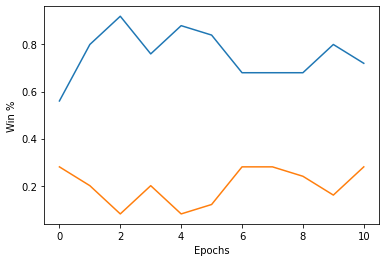

In [16]:
import matplotlib.pyplot as plt

plt.plot(team1_winRatio)
plt.plot(team2_winRatio)
plt.xlabel('Epochs')
plt.ylabel('Win %')
plt.show()